# Part 2

In [ ]:
#run the following if you use Google Colab
#!pip3 install numpy torch torchvision
#!pip install Pillow==4.0.0
#!pip install PIL
#!pip install image

In [45]:
import torch
from torchvision import models,transforms,datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline 

In [46]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.manual_seed(42)

In [47]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root=".",
                   train=True,
                   download=True,
                   transform=transforms.Compose(
                       [transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))]
                   )
                  ),
    batch_size=64,
    shuffle=True)

In [ ]:
valid_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root=".",
                   train=False,
                   download=True,
                   transform=transforms.Compose(
                       [transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))]
                   )
                  ),
    batch_size=64,
    shuffle=True)

In [49]:
data, labels = next(iter(train_loader))

In [50]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet,self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc_layer1 = nn.Linear(4*4*50, 500)
        self.fc_layer2 = nn.Linear(500, 10)


    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc_layer1(x))
        x = self.fc_layer2(x)
        return F.log_softmax(x, dim=1)

model = ConvNet().to(device)

In [51]:
optimizer=optim.SGD(model.parameters(),lr=0.01)


def train(epoch):
    validation_error = []
    training_error = []
    for i in range(epoch):
        for type_training in ["train","eval"]:
            loss_total=0
            correct_total=0

            if type_training == "train":
                model.train()

                for data, labels in train_loader:
                    data, labels=data.to(device), labels.to(device)

                    optimizer.zero_grad()
                    output=model(data)
                    pred=torch.argmax(output,1)
                    loss=F.nll_loss(output,labels)

                    loss.backward()
                    optimizer.step()

                    loss_total+=loss
                    correct_total+=(pred == labels).sum()
                    
                train_accuracy = correct_total.item()/len(train_loader.dataset)

                print(f"Epoch is {i+1}")
                print(f"Train Loss is {loss_total.item()}")
                print(f"Train Accuracy is {train_accuracy}")
                
                training_error.append(1-train_accuracy)


            if type_training == "eval":
                model.eval()

                for data, labels in valid_loader:
                    data, labels=data.to(device), labels.to(device)

                    optimizer.zero_grad()

                    with torch.no_grad():
                        output=model(data)
                        pred=torch.argmax(output,1)
                        loss=F.nll_loss(output,labels)

                        loss_total+=loss
                        correct_total+=(pred == labels).sum()

                Eval_accuracy = correct_total.item()/len(valid_loader.dataset)
                
                print(f"Eval Loss is {loss_total.item()}")
                print(f"Eval Accuracy is {Eval_accuracy}")              
                
                validation_error.append(1-Eval_accuracy)


    return model, training_error, validation_error

In [52]:
model, training_error, validation_error = train(10)

Epoch is 1
Train Loss is 427.62158203125
Train Accuracy is 0.8791333333333333
Eval Loss is 27.42966651916504
Eval Accuracy is 0.9459
Epoch is 2
Train Loss is 121.4101791381836
Train Accuracy is 0.9620833333333333
Eval Loss is 20.94454574584961
Eval Accuracy is 0.9556
Epoch is 3
Train Loss is 84.63594055175781
Train Accuracy is 0.97355
Eval Loss is 10.239175796508789
Eval Accuracy is 0.9799
Epoch is 4
Train Loss is 66.962158203125
Train Accuracy is 0.9781333333333333
Eval Loss is 8.18886947631836
Eval Accuracy is 0.9852
Epoch is 5
Train Loss is 57.086952209472656
Train Accuracy is 0.98155
Eval Loss is 10.461355209350586
Eval Accuracy is 0.9794
Epoch is 6
Train Loss is 49.51540756225586
Train Accuracy is 0.9844
Eval Loss is 8.170038223266602
Eval Accuracy is 0.9826
Epoch is 7
Train Loss is 43.81359100341797
Train Accuracy is 0.98615
Eval Loss is 7.530579566955566
Eval Accuracy is 0.9855
Epoch is 8
Train Loss is 39.242469787597656
Train Accuracy is 0.98745
Eval Loss is 6.309435844421387
E

#### Plot the train and valid errors at the end of each epoch for the model.

Text(0,0.5,'Error')

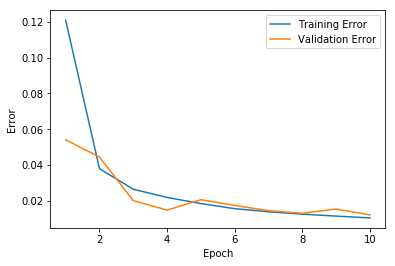

In [53]:
plt.plot(np.arange(1,len(training_error)+1),training_error)
plt.plot(np.arange(1,len(training_error)+1),validation_error)
plt.legend(["Training Error","Validation Error"])
plt.xlabel("Epoch")
plt.ylabel("Error")

#### 1. Come up with a CNN architecture with more or less similar number of parameters as MLP trained in Problem 1 and describe it

The input data is 28 x 28
We used a batch size of 64

The first layer is composed of a convolution with a square kernel of size 5, a stride of 1, no padding and 20 output channel (100 parameters and the output is 20x24x24).
This is follow by a max pooling layer with a kernel of size 2 and a stride of 2 (no overlapping) (output is 20x12x212)
with a ReLU acctivation fonction

After there is another convolution with a square kernel of size 5, a stride of 1, no padding and 50 output channel (5000 parameters and the output is 50x8x8).
This is follow by a max pooling layer with a kernel of size 2 and a stride of 2 (no overlapping) (output is 50x4x4)
with a ReLU acctivation fonction

After there is a first fully connected hidden layer with 500 hidden units (400 000 parameters) and a ReLU acctivation fonction

Finally the output layer is a fully connected layer with 10 hidden units and a softmax activation (5000 parameters)

The model has 410 100 parameters in total.



#### 2. Compare the performances of CNN vs MLP. Comment.

The CNN has a much stronger performance on both the training and validation data. The CNN has 1.04\% on the training, 1.21\% on the validation error after 10 epoch vs 6.35\%  on the validation error for the MLP after 10 epoch with the Glorot initialisation. The CNN also outperform the best mlp model find with hyperparamater search which has 2.5\% errors on validation. CNN is design to perform well on image. It uses local connectivity and parameter sharing to reduce the number of parameters to learn. CNN also uses pooling to reduce the number of hidden units in a hidden layer and makes the algorithm invariant to small translations in the sample, which is a desirable characteristic of an image classifier. We see that these design characteristics make a difference when we compared the CNN result with the MLP result.